# 1. Import the required libraries

In [2]:
# Standard code libraries
import os
import matplotlib.pyplot as plt
import numpy as np

# Custom code libraries from ReSurfEMG
from resurfemg.helper_functions.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.preprocessing import filtering as filt
from resurfemg.postprocessing import features as feat
from resurfemg.preprocessing import ecg_removal as ecg_rm
from resurfemg.postprocessing import quality_assessment as qa
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the sEMG data

In [3]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()

# Then find the files for the selected patients:
base_path = config.get_directory('root_emg_directory')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    #file_name_regex='emg_data_synth_pocc',
    extension_regex='poly5',
    folder_levels=None)


In [4]:
# If you want to select another file:
btn_list_emg = ipy_widgets.file_select(
    emg_files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('4_ontslag_20230421_132716.Data8Raw.Poly5', '4_o…

In [5]:
# Load the EMG  data recordings from the selected folders.
#emg_file_chosen = os.path.join(base_path, emg_files['files'].values[0])
# Alternatively:
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])

data_emg = Poly5Reader(emg_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate

n_ch = 4
# Define the time series of the EMG recording
y_emg = data_emg_samples[:n_ch,:]

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]

Reading file  M:/Documents/CRPH/Cooperations/UMCG_USIsala/UNDATED_sEMGpt4en5\4_ontslag_20230421_132716.Data8Raw.Poly5
	 Number of samples:  445185 
	 Number of channels:  21 
	 Sample rate: 500 Hz
Done reading data.


In [6]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['Intercost','Dia R','Dia L', 'Abd'],
    units=n_ch*['uV'])


# Data is stored in:
# fs        --> emg_timeseries.fs
# labels    --> emg_timeseries.labels
# units     --> emg_timeseries.units
# ECG       --> emg_timeseries.channels[0] = TimeSeries object
# EMGdi     --> emg_timeseries.channels[1: TimeSeries object
#   with:
#   emg_timeseries.channels[0].fs = fs
#   emg_timeseries.channels[0].y_raw = y_emg[0, :]
#   emg_timeseries.channels[0].t_data = time axis data for y_raw
#   emg_timeseries.channels[0].y_clean = None
#   emg_timeseries.channels[0].y_baseline = None
#   emg_timeseries.channels[0].y_baseline = None
#   etc.
# From the labels 'ECG' is automatically detected.

# 3. Pre-process the data

In [7]:
# Filter
emg_timeseries.filter(lp_cf=200)
# Which equals:
# emg_timeseries.filter(
#     signal_type='raw',
#     hp_cf=20.0,
#     lp_cf=500.0,
#     channel_idxs=[0, 1],
# )
# Where:
# signal_type:      Filter the raw, just assigned, data
# hp_cf:            High-pass cut-off frequency of 20 Hz
# lp_cf:            Low-pass cut-off frequency of 500 Hz
# channel_idxs:     For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean


500 20.0 200
500 20.0 200
500 20.0 200
500 20.0 200


In [8]:
#piekdetectie op kanaal 0 (intercostaal) - ecg_peak_idxs in gating stoppen
ts_0 = emg_timeseries.channels[0]
y_0 = ts_0.y_raw + 0
ecg_raw_test = filt.emg_bandpass_butter(
                    y_0, high_pass=1, low_pass=200, fs_emg=ts_0.fs)

ecg_peak_idxs_test = ecg_rm.detect_ecg_peaks(
                ecg_raw=ecg_raw_test,
                fs=fs_emg,
                bp_filter=True)

500 1 200
500 1 225.0


In [9]:
# Gate the EMG
emg_timeseries.gating(
    ecg_raw = y_0,
    gate_width_samples=emg_timeseries.fs//5,
    ecg_peak_idxs = ecg_peak_idxs_test)
# Which equals:
# emg_timeseries.gating(
#     signal_type='clean',
#     gate_width_samples=None,
#     ecg_peak_idxs=None,
#     ecg_raw=None,
#     bp_filter=True,
#     channel_idxs=None,
# )
# Where:
# signal_type:          Filter the clean, just filtered, data
# gate_width_samples:   Gate width, `None` defaults to fs // 10
# ecg_peak_idxs:        Sample idxs of ECG peaks, when `None` peaks are
#                       automatically identified.
# ecg_raw:              ECG data to detect ECG peaks in if no ecg_peak_idxs are
#                       provided. If `None` and no ecg-channel is detected
#                       from the labels the raw channel data is used.
# bp_filter:            True/False: Filter the provided ecg_raw between 1-500
#                       Hz before peak detection
# channel_idxs:         For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean


In [10]:
# Calculate the envelope of the signal
emg_timeseries.envelope(env_window=200)
# Which equals:
# emg_timeseries.envelope(
#     env_window=None,
#     env_type='rms',
#     signal_type='clean',
# )
# Where:
# env_window:           Envelope window width, `None` defaults to fs // 5
# env_type:             'rms' for root-mean-square (default), 'arv' for average
#                       rectified
# signal_type:          Calculate the envelope over the clean data

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_env

In [11]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.baseline()
# Which equals:
# emg_timeseries.baseline(
#     percentile=33,
#     window_s=int(7.5 * fs_emg),
#     step_s=fs_emg // 5,
#     method='default',
#     signal_type='env',
#     augm_percentile=25,
#     ma_window=None,
#     perc_window=None,
#     channel_idxs=[0, 1],
# )
# Where:
# percentile:       Percentile of signal in the window to take as the baseline
#                   value
# window_s:         Window length in samples (default: int(7.5 * fs))
# step_s:           Number of consecutive samples with the same baseline value
#                   (default: fs // 5)
# method:           'default' or 'slopesum'
# signal_type:      Calculate the baseline over the envelope (y_env) for emg
#                   and over the original signal for p_vent
# augm_percentile   Augmented_percentile for slopesum baseline
# ma_window:        Moving average window in samples for average dy/dt in
#                   slopesum baseline
# perc_window:      'perc_window' for slopesum baseline.
# channel_idxs:     For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_baseline


Text(0.5, 0, 't (s)')

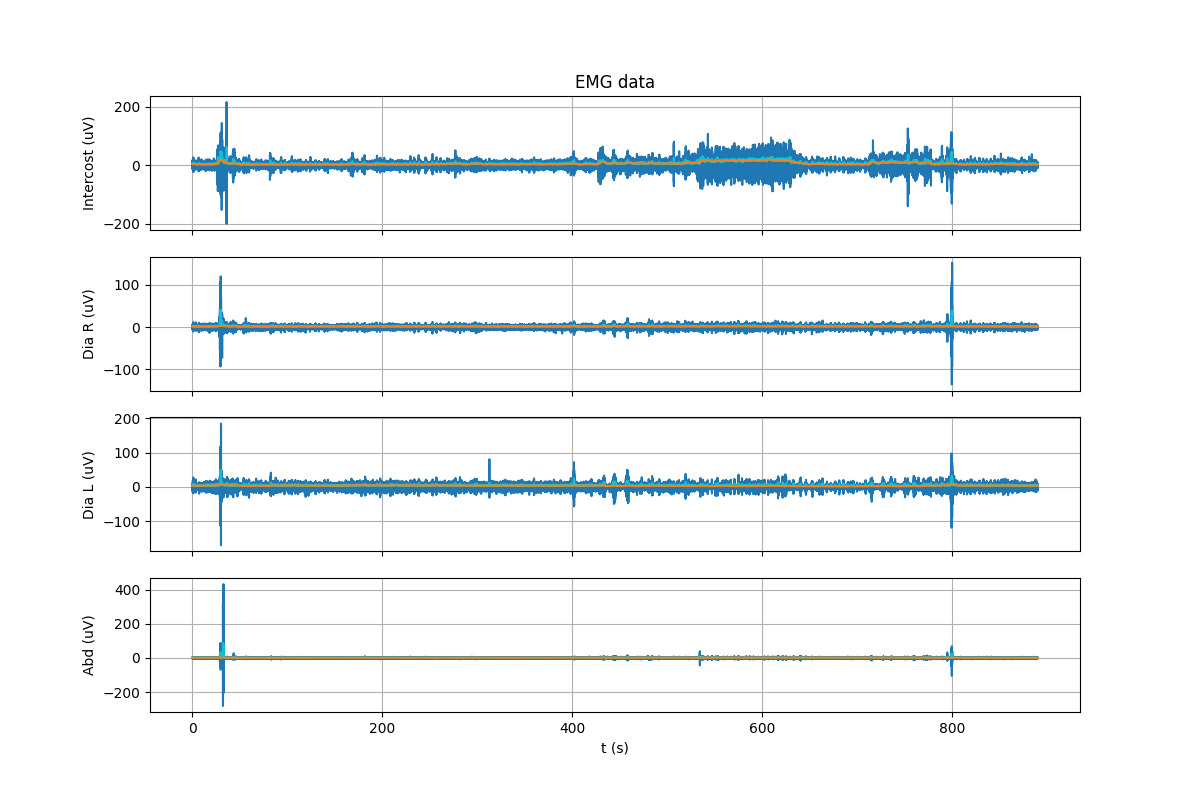

In [28]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=n_ch, ncols=1, figsize=(12, n_ch/3*6), sharex=True)
axes_emg = axis[:n_ch]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.plot_full(
    axes=axes_emg, signal_type='clean', baseline_bool=False)
# Which equals:
# emg_timeseries.plot_full(
#     axes=axes_emg,
#     channel_idxs=[0, 1],
#     signal_type='clean',
#     colors=['tab:cyan', 'tab:orange'],
#     baseline_bool=False
# )
# Where:
# axes:             Matplotlib axes object
# channel_idxs:     For all channels (None would default to this)
# signal_type:      Plot clean emg
# colors:           Plot the signal, and baseline in the respective colors
# baseline_bool:    Plot the baseline

emg_timeseries.plot_full(axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# 3. Identify all sEMG breaths

In [13]:
# Find sEAdi peaks in one channel (sEAdi)
emg_di_r = emg_timeseries.channels[1]
emg_di_r.detect_emg_breaths(peak_set_name='breaths')


emg_di_r.peaks['breaths'].detect_on_offset(
    baseline=emg_di_r.y_baseline
)
# --> Peak data is stored in:
# emg_di.peaks['breaths']

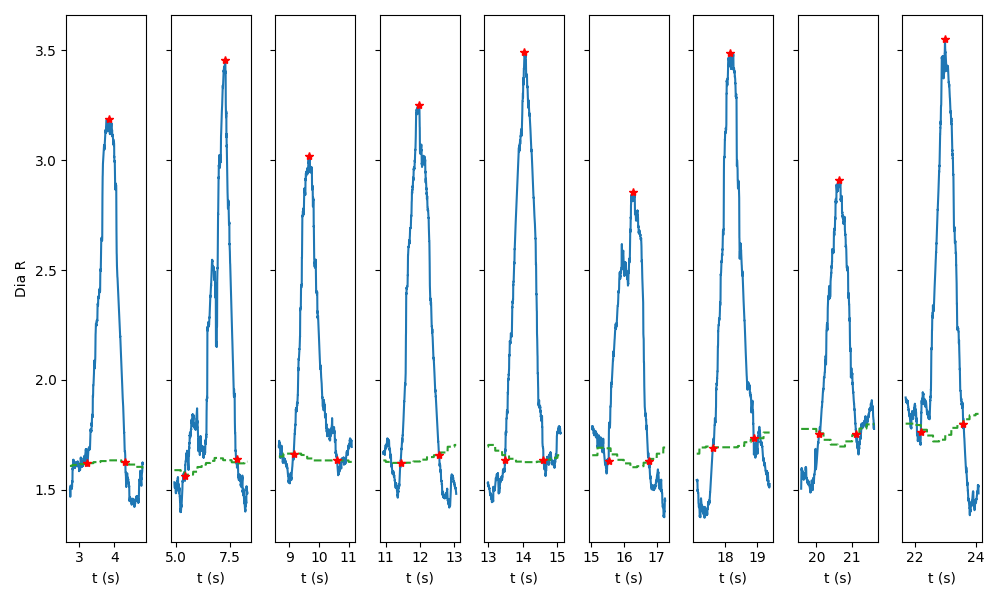

In [ ]:
# Select the peaks to plot
peak_df = emg_di_r.peaks['breaths'].peak_df.iloc[1:10]

# Define the number of samples to plot before and after the peak
margin_samples = emg_di_r.fs // 2  # Half a second before and after

# Plot the selected peaks for sEAdi
n_peaks = len(peak_df)
fig, axis = plt.subplots(nrows=1, ncols=n_peaks, figsize=(10, 6), sharey='row')

# Ensure axes_emg is always a list of axes
if n_peaks == 1:
    axes_emg = [axis]
else:
    axes_emg = axis[:]

colors = ['tab:cyan', 'tab:orange', 'tab:red']

# Plot each selected peak individually
for i, row in enumerate(peak_df.itertuples()):
    start_idx = max(row.start_idx - margin_samples, 0)
    end_idx = min(row.end_idx + margin_samples, len(emg_di_r.y_env))

    # Extract the segment of the signal corresponding to the peak
    segment = emg_di_r.y_env[start_idx:end_idx]
    time = emg_di_r.t_data[start_idx:end_idx]

    # Plot the segment
    axes_emg[i].plot(time, segment, color='tab:blue')

    # Plot the baseline
    baseline_segment = emg_di_r.y_baseline[start_idx:end_idx]
    axes_emg[i].plot(time, baseline_segment, color='tab:green', linestyle='--')

    # Plot the markers manually with red asterisks
    axes_emg[i].plot(emg_di_r.t_data[row.start_idx], emg_di_r.y_env[row.start_idx], 'r*')  # Start marker
    axes_emg[i].plot(emg_di_r.t_data[row.end_idx], emg_di_r.y_env[row.end_idx], 'r*')      # End marker
    peak_idx = row.peak_idx
    axes_emg[i].plot(emg_di_r.t_data[peak_idx], emg_di_r.y_env[peak_idx], 'r*')           # Peak marker

# Set labels
axes_emg[0].set_ylabel(emg_di_r.label)
for ax in axes_emg:
    ax.set_xlabel('t (s)')

plt.tight_layout()
plt.show()


# 5. Calculate features

In [15]:
# Respiratory rate

emg_di_idxs = emg_di_r.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_emg, _ = feat.respiratory_rate(
    emg_di_idxs, fs_emg
)

# rr_vent,
rr_emg

25.188916876574307

In [16]:
# Get the indices of all detected breaths
breath_peak_idxs = emg_di_r.peaks['breaths'].peak_df['peak_idx'].to_numpy()

# Calculate the amplitude of all detected breaths
sEAdi_amplitudes_dia_r = feat.amplitude(
    signal=emg_di_r.y_env,
    peak_idxs=breath_peak_idxs,
    baseline=emg_di_r.y_baseline,
)

In [17]:
# Calculate the area under the curve (AUC) for all detected breaths
emg_di_r.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')

# Store the AUC values in a variable
sEAdi_auc_di_r = emg_di_r.peaks['breaths'].peak_df['AUC'].to_numpy()



In [18]:
print(emg_di_r.peaks['breaths'].peak_df.columns)


Index(['peak_idx', 'start_idx', 'end_idx', 'valid', 'AUB', 'aub_y_ref', 'AUC'], dtype='object')


# 6. Test sEMG quality

In [19]:
# Test EMG quality
parameter_names = {
    'time_product': 'AUB'
}
emg_di_r.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names)
# Which equals:
# emg_di.test_emg_quality(
#     peak_set_name='Pocc',
#     cutoff={
#         'interpeak_distance': 1.1,
#         'snr': 1.4,
#         'aub': 40,
#         'curve_fit': 30,
#         'aub_window_s': 5*emg_di.fs
#     },
#     skip_tests=[],
#     parameter_names={
#         'time_product': 'ETPdi'
#     },
#     verbose=True
# )
# Where:
# peak_set_name:        Peakset to test
# cutoff:               The cut-off values for the tests
# skip_tests:           List of tests to skip. Any of: 'interpeak_dist',
#                       'snr', 'aub', 'curve_fit'
# parameter_names:      Dictionary of renamed parameters. Required parameters
#                       are ['interpeak_distance', 'snr', 'aub', 'curve_fit'],
#                       and need to be specified if renamed.
# verbose:              Print the output of the tests

# --> Peak quality data is stored in:
# emg_di.peaks['Pocc'].quality_values_df and
# emg_di.peaks['Pocc'].quality_outcomes_df

Test values:
     peak_idx       snr        aub  aub_y_refs       bell
0         456  2.424252  21.719625    1.357893  52.988852
1        1926  1.964402  24.506326    1.357893  25.235068
2        3653  2.121014  26.306000    1.398777  98.864965
3        4837  1.838077  29.608751    1.398777  52.055022
4        5987  1.993471  20.788372    1.401082  28.440042
..        ...       ...        ...         ...        ...
358    439479  1.389011  46.580363    1.467640  24.861402
359    440729  1.933461  23.293737    1.467640  20.987943
360    442040  1.479312  40.324878    1.420289  20.097904
361    443151  1.547088  42.517763    1.420289  31.617794
362    444124  1.769323  28.479840    1.420289  17.814355

[363 rows x 5 columns]
Test outcomes:
     peak_idx  baseline_detection  interpeak_distance    snr    aub   bell
0         456                True                True   True   True  False
1        1926                True                True   True   True   True
2        3653              

In [20]:
quality_outcomes_df = emg_di_r.peaks['breaths'].quality_outcomes_df

# Count the number of False values in each specified column
columns_to_check = ['baseline_detection', 'interpeak_distance', 'snr', 'aub', 'bell']
false_counts = quality_outcomes_df[columns_to_check].apply(lambda col: (col == False).sum())

# Print the results
print(false_counts)

baseline_detection     22
interpeak_distance      0
snr                    75
aub                   139
bell                  166
dtype: int64


In [21]:
print(emg_di_r.peaks['breaths'].quality_outcomes_df)

     peak_idx  baseline_detection  interpeak_distance    snr    aub   bell
0         456                True                True   True   True  False
1        1926                True                True   True   True   True
2        3653                True                True   True   True  False
3        4837                True                True   True   True  False
4        5987                True                True   True   True   True
..        ...                 ...                 ...    ...    ...    ...
358    439479                True                True  False  False   True
359    440729                True                True   True   True   True
360    442040                True                True   True  False   True
361    443151                True                True   True  False  False
362    444124                True                True   True   True   True

[363 rows x 6 columns]


In [22]:
# The peak-validity is updated in the peak_df:
print(emg_di_r.peaks['breaths'].peak_df)

     peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref       AUC  \
0         456          0      974  False  0.516379   1.357893  2.377476   
1        1926       1615     2156   True  0.293757   1.357893  1.198700   
2        3653       2713     3916  False  0.521251   1.398777  1.981491   
3        4837       4572     5304  False  0.358929   1.398777  1.212239   
4        5987       5715     6276   True  0.263762   1.401082  1.268797   
..        ...        ...      ...    ...       ...        ...       ...   
358    439479     439177   439667  False  0.319065   1.467640  0.684977   
359    440729     440403   440980   True  0.326738   1.467640  1.402686   
360    442040     441784   442177  False  0.252448   1.420289  0.626036   
361    443151     442651   443456  False  0.493297   1.420289  1.160213   
362    444124     443866   444418   True  0.323090   1.420289  1.134451   

     bell_y_min    bell_a      bell_b    bell_c  
0      1.357893  2.330589    0.921230  0.579170  

C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_9176\907712053.py:39: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


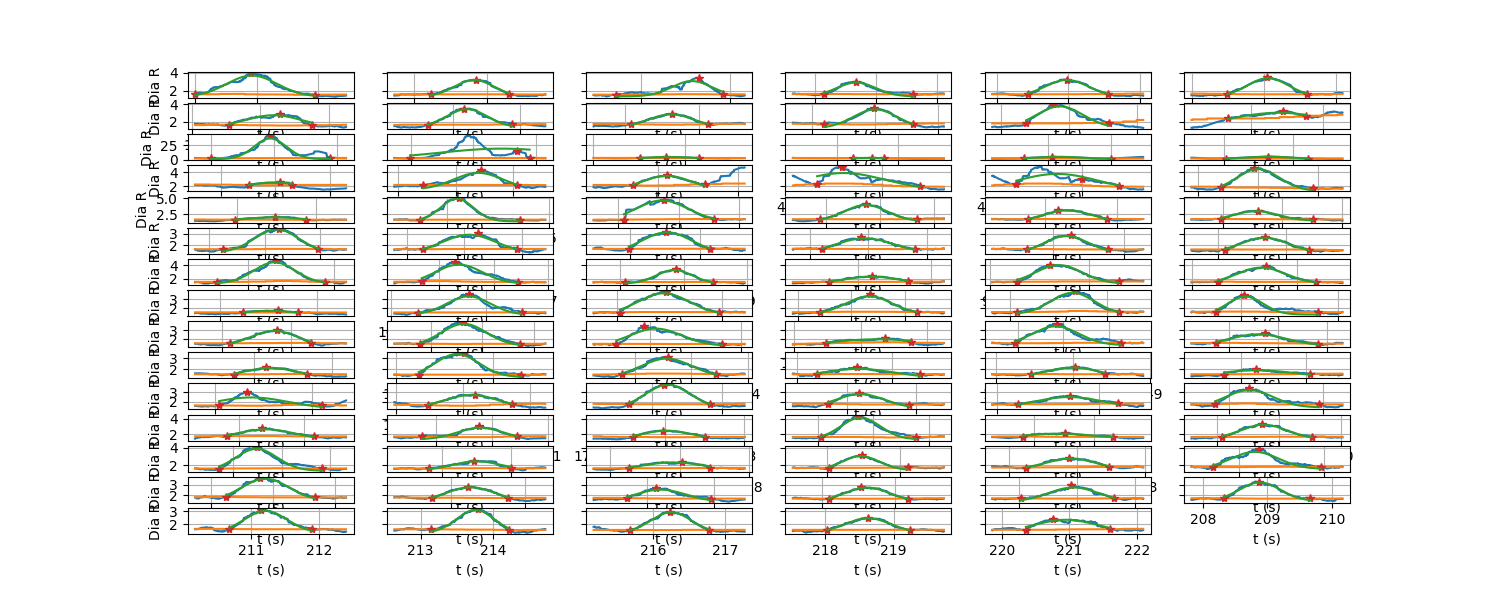

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame to include only valid peaks
valid_peaks_df = emg_di_r.peaks['breaths'].peak_df[emg_di_r.peaks['breaths'].peak_df['valid'] == True]

# Get the number of valid peaks
n_peaks = len(valid_peaks_df['start_idx'].to_numpy())

# Define the maximum number of columns
max_cols = 6

# Calculate the number of rows needed
n_rows = int(np.ceil(n_peaks / max_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=max_cols, figsize=(15, 6), sharey='row')

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Ensure axes_emg is always a list of axes
axes_emg = axes_flat[:n_peaks]

colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di_r.plot_peaks(axes=axes_emg, peak_set_name='breaths')
emg_di_r.plot_markers(axes=axes_emg, peak_set_name='breaths')
emg_di_r.plot_curve_fits(axes=axes_emg, peak_set_name='breaths')

# Set labels for the first column and all axes
for i, axis in enumerate(axes_emg):
    if i % max_cols == 0:
        axis.set_ylabel(emg_di_r.label)
    axis.set_xlabel('t (s)')

# Hide any unused subplots
for j in range(n_peaks, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()


In [24]:
# Calculate the number of breaths in valid peaks
num_valid_breaths = len(valid_peaks_df)

print(f"The number of breaths in valid peaks is {num_valid_breaths}.")

mean_auc = valid_peaks_df['AUC'].mean()
print(f"The mean value of the attribute 'auc' for the valid breaths is {mean_auc}.")
# Calculate the median value of the attribute 'aub' for the valid breaths
median_auc = valid_peaks_df['AUC'].median()

print(f"The median value of the attribute 'auc' for the valid breaths is {median_auc}.")
# Calculate the standard deviation of the attribute 'aub' for the valid breaths
std_auc = valid_peaks_df['AUC'].std()

print(f"The standard deviation of the attribute 'auc' for the valid breaths is {std_auc}.")



The number of breaths in valid peaks is 89.
The mean value of the attribute 'auc' for the valid breaths is 1.5143561843770674.
The median value of the attribute 'auc' for the valid breaths is 1.3655831523929751.
The standard deviation of the attribute 'auc' for the valid breaths is 0.6188508936661978.


In [ ]:
# Detect local high baselines in EMGdi
emg_di_r.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUB')
emg_di_r.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


emg_di_aubs = emg_di_r.peaks['breaths'].peak_df['AUB'].to_numpy()
valid_aubs = qa.detect_local_high_aub(
    aubs=emg_di_aubs,
    threshold_percentile=75,
    threshold_factor=4,
)
valid_aubs


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [26]:
ETPdi_r_list = emg_di_r.peaks['breaths'].peak_df['AUB'].to_numpy()
valid_etps = qa.detect_extreme_time_products(
    ETPdi_r_list,
    upper_percentile=95.0,
    upper_factor=10.0,
    lower_percentile=5.0,
    lower_factor=.1,
)
valid_etps


array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      